In [32]:
#!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from dmodel import Unet

In [33]:
# linear beta schedule
def linear_beta_schedule(n_timesteps=1000, start=1e-5, end=1e-2):
    betas = torch.linspace(-6, 6, n_timesteps)
    betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [34]:
timesteps = 100
betas = linear_beta_schedule(timesteps)

# alphas
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)

alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod) # stddev

def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

In [35]:
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0) # identity
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [36]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("mnist")
image_size = 28
channels = 1
batch_size = 128

Found cached dataset mnist (/Users/tina/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [63]:
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]

    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [38]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [39]:
# samling x_t-1
@torch.no_grad()
def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

@torch.no_grad()
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(timesteps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [40]:
@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [41]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [42]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [66]:
def noise_estimation_loss(model, x_0, t):
    '''
    batch_size = x_0.shape[0]
    # Select a random step for each example
    #t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    #t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    
    output = model(x, t)
    return (e - output).square().mean()
    '''
    noise = torch.randn_like(x_0)
    x_noisy = q_sample(x_0=x_0, t=t, noise=noise)
    predicted_noise = model(x_noisy, t)
    
    return F.mse_loss(noise, predicted_noise).mean()

In [ ]:
from torchvision.utils import save_image

epochs = 3
samples = []

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        #loss = p_losses(model, batch, t, loss_type="huber")
        loss = noise_estimation_loss(model, batch, t)

        if step % 100 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

      # save generated images
        #if step != 0 and step % save_and_sample_every == 0:
    #milestone = step // save_and_sample_every
    #batches = num_to_groups(4, batch_size)
    #all_images_list = list(map(lambda n: sample(model, image_size=image_size, batch_size=n, channels=channels), batches))
    #all_images = torch.cat(all_images_list, dim=0)
    #all_images = (all_images + 1) * 0.5
    #save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
    #samples.append(sample(model, image_size=image_size, batch_size=64, channels=channels))
    #plt.imsave('test/{0}.jpg'.format(str(epoch)), samples[-1][5].reshape(image_size, image_size), cmap="gray")

Loss: 0.0946451723575592
Loss: 0.10221751034259796
Loss: 0.09338408708572388
Loss: 0.09892953187227249
Loss: 0.09793435782194138
Loss: 0.1037047877907753
Loss: 0.09351672977209091
Loss: 0.10443670302629471
Loss: 0.09460807591676712
Loss: 0.09093816578388214
Loss: 0.10357480496168137
Loss: 0.08941715955734253
Loss: 0.09095977991819382
Loss: 0.09070239216089249
Loss: 0.08849019557237625
Loss: 0.08917006105184555


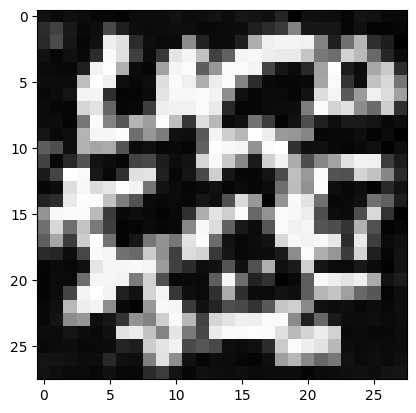

In [58]:
random_index = 5
plt.imshow(samples[-1][-1][0].reshape(image_size, image_size, channels), cmap="gray")